# SLURM (= Simple Linux Utility Resource Manager)
SLURM is a software to manage computational resources. It's primary use case is a high performance computing cluster that consist of multiple nodes, many compute cores (CPUs) and heaps of memory and are used concurrently by many users.

## Some terminology
### Parallel computers
Virtually all stand-alone computers today are parallel from a hardware perspective:
* Multiple functional units (L1 cache, L2 cache, branch, prefetch, decode, floating-point, graphics processing (GPU), integer, etc.)
* Multiple execution units/cores
* Multiple hardware threads

![IBM BG/Q Compute Chip with 18 Cores](https://hpc.llnl.gov/sites/default/files/bgqComputeChip.jpeg)

A HPC System is basically a (fast) network of computers (aka "Nodes").

![Nodes connectec in a network](https://hpc.llnl.gov/sites/default/files/nodesNetwork.gif)

## Using wallace
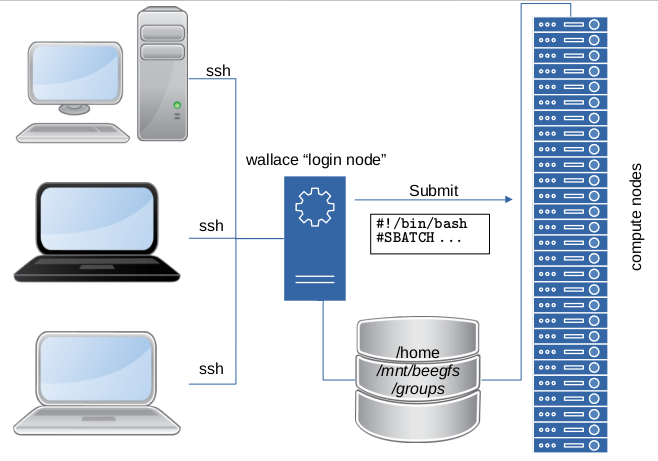

* Users connect via `ssh wallace`. They are then on the login node.
* Create scripts, copy data, tests (but no heavy work!)
* Submit HPC job (= resource allocation + script) via SLURM
* Data is written to $PWD or dedicated file/directory

## Some terminology
### Node
Some piece of hardware with a network socket
### CPU
Central Processing Unit, higher order hierarchical computing structure, bound to the global RAM
### Core
A CPU can have one or multiple cores.
### Thread
A thread is a sequence of instructions, running on a core. Some core support hyperthreading, more than 1 thread can be executed in parallel.

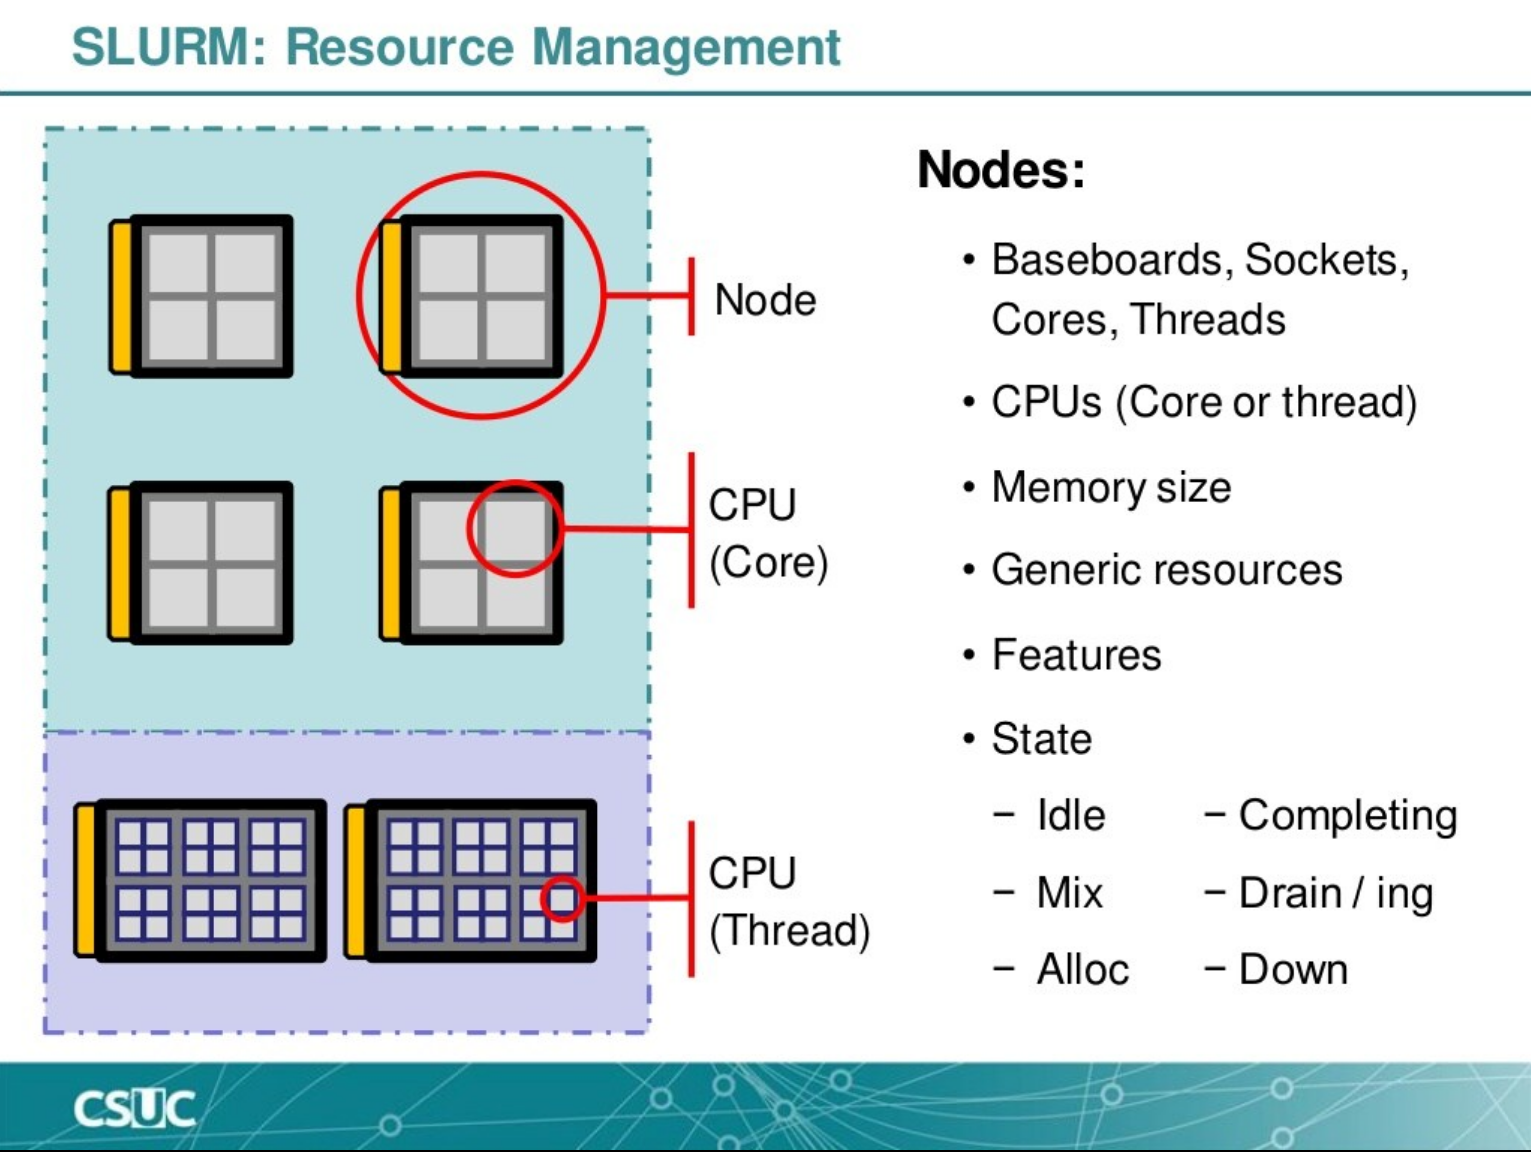  
Credits: [https://www.slideshare.net/CSUC_info/introduction-to-slurm](https://www.slideshare.net/CSUC_info/introduction-to-slurm)


### Job
A job is a collection of tasks that is submitted to the scheduler
### Task
The job is broken down into tasks that can be processed in parallel.
### Process
A process is a program that executes a task on allocated resourses.

## SLURM commands
### `sinfo`: Get information about the HPC system: Partitions, allocated/idle resources
### `squeue`: List of jobs and their run status (queued, running, ...)
### `sbatch`: Submit a job script to the scheduler
### `salloc`: Allocate resources for interactive work
### `scontrol`: List or edit job parameters
### `scancel`: Stop a job (identified by its job ID).

## sbatch scripts
Sbatch scripts are just that: scripts. They have one more syntactical element than ordinary (shell) scripts, the `#SBATCH` tag. Lines starting with `#SBATCH` 
contain a resource allocation request or other information for the scheduler.

### Example
```console
#!/bin/bash

#SBATCH --job-name=bcl2fastq
#SBATCH --ntasks=4
#SBATCH --nodes=1
#SBATCH --time=24:00:00
#SBATCH --mem=64G
#SBATCH --error=job.%J.err
#SBATCH --output=job.%J.out
#SBATCH --mail-type=ALL
#SBATCH --mail-user=grotec@evolbio.mpg.de
#SBATCH --partition=standard

module load perl/5.24.1

INDIR=$1
OUTDIR=$2
SAMPLESHEET=$3
MISBAR=$4

echo "NEXTSEQ RUN DIR: $INDIR"
echo "OUTPUT DIR: $OUTDIR"
echo "SAMPLESHEET: $SAMPLESHEET"
echo "BARCODE-MISMATCHES: $MISBAR"

hostname
date

bcl2fastq -R $INDIR -o $OUTDIR --sample-sheet $SAMPLESHEET --barcode-mismatches $MISBAR --no-lane-splitting

date
```

## The most frequent SBATCH options
Cheatsheet: [https://slurm.schedmd.com/pdfs/summary.pdf](https://slurm.schedmd.com/pdfs/summary.pdf)

### Resource allocation:
* `-N --nodes`: Number of nodes to allocate
* `-n --ntasks`: Number of tasks
* `--cpus-per-task`: Number of CPUs to allocate per task
* `--mem`: Memory per node (in MB)
* `--mem-per-cpu`: Memory per CPU (in MB)
* `-t --time`: Maximum time to complete the job (Wall time = time elapsed from start to end). Format: [days-]HH:MM:SS
* `-p --partition`: Which cluster partition to use. Use `sinfo` to get information about partitions.

### Job metadata
* `-J --job-name`: Give a name to the job (can be useful if many jobs are submitted at once).

### IO
* `-o --output`: File in which job output will be written.
* `-e --error`: File in which job errors will be written. If not given, errors go to output.

### Notification
* `--mail-type`: Which type of notifications to send, can be (ALL, START, STOP, FAIL)
* `--mail-user`: Email address of user to be notified (typically tihs is the submitter, don't spam your colleagues!).

## What software is available on wallace
* The directory */data/biosoftware/* contains a wealth of bioinformatic software. Take a look if the tool you're looking for is there.
* Sometimes, a certain tool requires a special version of `R`, `perl`, or `python`. 
Different versions of libraries and programming languages are maintained in *modules*. 

### Frequently used `module` commands
| command | comment |
|---------|---------|
| `module avail` | List all available commands |
| `module load <module name>` | Load  a module |
| `module list` | List all loaded module |
| `module unload <module name>` | Unload a given module |
| `module purge` | Unload all modules |

## Exercises

### Available software on wallace
* List the */data/biosoftware/* directory
* What modules are available on wallace?
* Load the `R` module
* Run `module list`
* Unload the `R` module.

### System information
* Login on wallace
* Which partitions are on the wallace cluster? How do they differ?
* Investigate the commands `lsmem` and `lscpu`. 
* Combine `lsmem` and `grep` in a pipeline to print out the total memory on a single line.
* Combine `lscpu` and `grep` in a pipeline to print out the number of CPUs on a single line.
* Write a script that reports the hostname, number of CPUs and the total memory in one line.
* Write a SLURM batch script that reserves 3 nodes on the `testing` partition and writes the hostname, total memory, and number of CPUs for each node. 
  Reuse the script written in the previous step. In the SLURM batch script, you have to envoke the reporting script with `srun`.

* Modify your sbatch script and add `sleep 30` before the `srun ...` command (also increase the allocated job time accordingly).
* Try to observe the run status of your job using `scontrol show job <job id>`.
* List your jobs with `squeue -u $USER`

#### Solutions
##### Shell script to get system memory and number of CPUs
```shell
#! /bin/bash

HOSTNAME=$(hostname)
MEM=$(lsmem | grep "^Total online memory")
NCPUS=$(lscpu | grep "^CPU(s)")

echo "$HOSTNAME: $NCPUS, $MEM"
```

##### Sbatch job script that runs *nodeinfo.sh* on 3 nodes
```shell
#! /bin/bash

#SBATCH -N 3
#SBATCH -t 00:00:10
#SBATCH -p testing
#SBATCH --output nodeinfo.txt

srun bash nodeinfo.sh
```

## Run the batch job
```console
$> sbatch nodeinfo.sbatch.sh
```

### Running multithreaded bioinformatic tools in parallel
The wallace cluster is optimized to run SIMD jobs and pipelines for bioinformatic data processing (sequence alignment and comparison, expression profiling). Many of the existing bioinformatic tools support multiprocessing, a simple form of parallelization. When switched on, multiple sequences or sequence files are processed in parallel to each other instead of serially one after the other. In this exercise, we will run the `breseq` command, a tool to compare short read sequences to a reference sequence, e.g. to identify mutations. `breseq` can be run with the option `-j N` where `N` is the number of threads over which to parallelize the process. In other words, at the start of the process, the first `N` sequences are read in and processed in parallel, one sequence per thread. When a sequence is processed, the next sequence is read in and so forth.

The crucial point to make here is that `N` cannot be larger than the number of cores (or threads) on a single node. In order to take advantage of the many cores in a multinode HPC cluster, we have to do some more work:
* Split up the sequences into $M$ chunks, one chunk per node
* Process each chunk with the $-j$ option, such that sequences in a chunk are processed in parallel.

The directory */mnt/beegfs/grotec/hpc_course/fastq* contains sequence data from a resequencing project of Pseudomonas fluorescens SBW25 mutants. Each file corresponds to a certain sample and contains many short read sequences. The aim of this exercise is to develop an sbatch job script that runs the resequence analysis tool 
`breseq` on these files. The syntax for `breseq` is as follows:

```console
$> breseq -n <job name> -o <output_dir> -j <number of parallel threads> -r <reference data> <forward reads> <reverse reads>`
```

The filenames follow the pattern *SampleName_SampleID_R[1,2]_001.fastq.gz*. The token *R1* indicates forward reads, *R2* indicates reverse reads.

The reference datafile is */mnt/beegfs/grotec/hpc_course/ASM922v1.37.dat*

## Exercises
### One sbatch job per sample

* Pick 5 samples
* For one of your samples, write a sbatch script named *job_1.sh*.
* Allocate  one node, 24 CPUs and 64 GB of memory.
* Instruct breseq to write output to */mnt/beegfs/<username>/breseq_out/*
* Launch the sample's `breseq` run with script with `srun breseq ...`.
* Test your script on the testing partition
* If everything works, delete the output from the test runs, write the sbatch job scripts for the remaining 4 samples and submit
    them all with `sbatch job_<i>.sh`.
    
**Note**: breseq requires R and python, include the lines

```shell
module load R
module load python/python-anaconda3_2020.02
```

## Job Array
A SLURM job array is a list of integers defined via a range of numbers (limits inclusive)
```
#SBATCH --array 0-39
```
or explicitely
```
#SBATCH --array 1,3,5,7
```
or with a step size
```
#SBATCH --array 1-7:2
```

The array index can be communicated to the command section of the sbatch command, e.g.
```
#!/bin/bash
#SBATCH -N1
#SBATCH -n10
#SBATCH -a 0-9

srun job_%a.sh
```
would launch jobs defined in the scripts *job_0.sh* through *job_9.sh*.

### Exercise:

Modify your sbatch and sample scripts to make use of the job array.

### One multi-prog job
Here we write just one sbatch job script. 
We allocate one task per sample, one node per task and 24 CPUs per task.
In the sbatch script, we
run `srun --multi-prog breseq.conf`

breseq.conf is a 3 column text file that lists in each row  the task index,  the command to run (`source`),
and the command line options (`job_<i>.sh`).


* Write the sbatch job script according to the specifications given above.

#### Solution
![image.png](../img/a894f883-0a76-4486-bc17-61594662cb8e.png)
![image.png](../img/61c63efb-1119-499e-86c0-5f20203b5e1c.png)
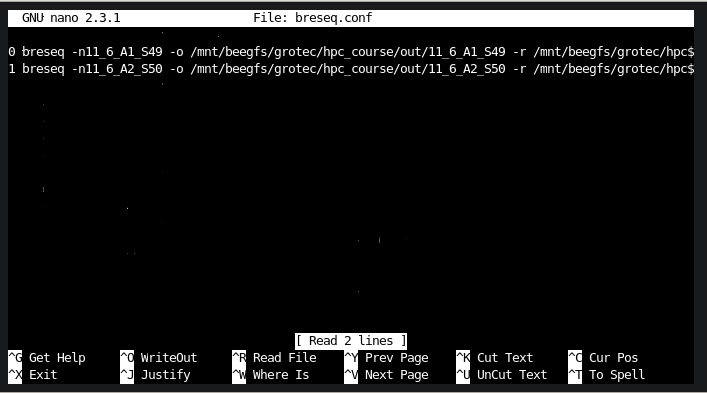
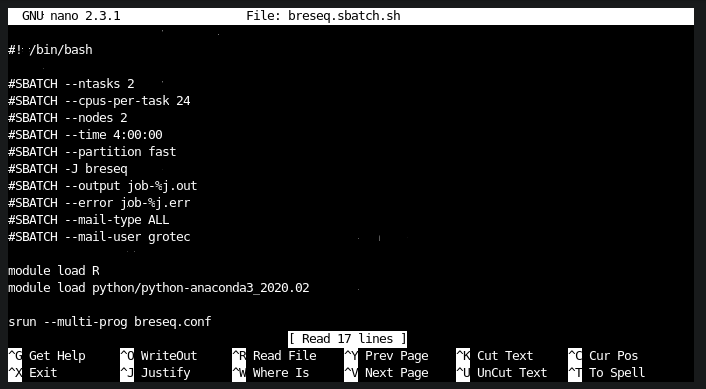

* Submit your job to SLURM
* Monitor the status of your job with `squeue -u $USER`.
* Login on the compute node with `ssh`
* Run `htop` to visualize the resource consumption while `breseq` runs.

```console
$> ssh fastnode01
$> htop
```
![image.png](../img/0d5950a6-88f7-42ca-8d3d-fac764fa880b.png)

```console
$> ssh fastnode02
$> htop
```
![image.png](../img/1269d5b4-db53-4aa8-9212-874913b6bf73.png)
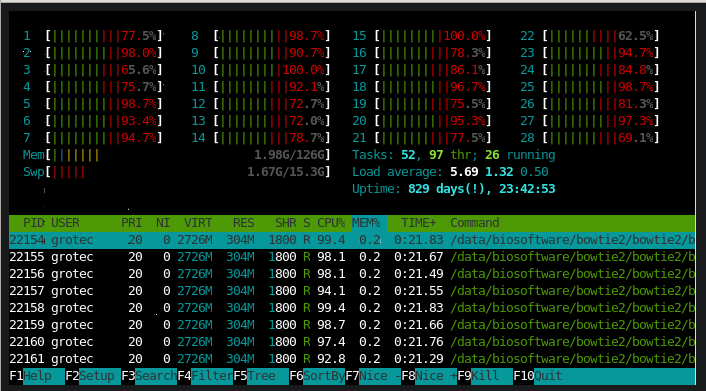
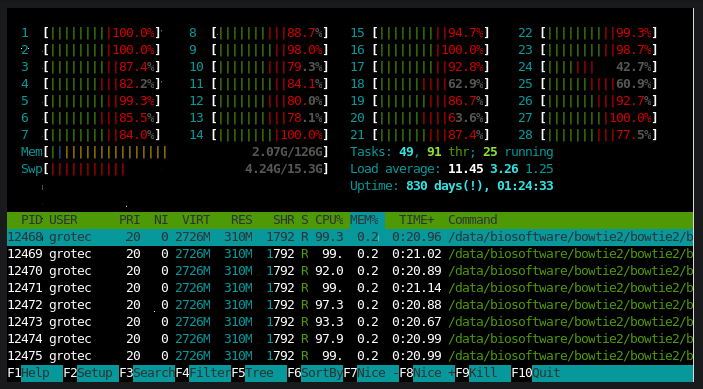